<a href="https://colab.research.google.com/github/Abe-Kon/Capstone_EmbeddedMLwEI/blob/main/wakeword_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Wakeword model v4.

@Abena Osei-Akoto
Capstone: Embedded Machine Learning Without Edge Impulse

Supervisor: Dr Nathan Amanquah

Importing neccessary dependencies

In [1]:
# checking tensorflow version
import tensorflow as tf
print(tf.__version__)

2.12.0


In [2]:
# Upgrade environment to support TF 2.12 in Colab

!pip install -U --pre tensorflow tensorflow_datasets
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 37.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 53.7 MB/s eta 0:00:00
  Attempting uninstall: tensorflow_datasets
    Found existing installation: tensorflow-datasets 4.8.3
    Uninstalling tensorflow-datasets-4.8.3:
      Successfully uninstalled tensorflow-datasets-4.8.3
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages will be REMOVED:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be DOWNGRADED:
  libcudnn8
0 upgraded, 0 newly installed, 1 downgraded, 1 to remove and 22 not upgraded.
Need to get 430 MB of archives.
After this operation, 1,153 MB disk space will be freed.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  libcudnn8 8.1.0.77-1+cuda1

In [3]:
# Import necessary libraries
import pathlib 
import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

In [4]:
# Set the seed value for experiment reproducibility.
seed = 30032023
tf.random.set_seed(seed)
np.random.seed(seed)

Data Collection

In [5]:
from google.colab import files
files.upload()

Saving speech_yeswav.zip to speech_yeswav.zip


{'speech_yeswav.zip': b'PK\x03\x04\x14\x00\x00\x00\x00\x00\t\x8e\x93V\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x0e\x00 \x00speech_yeswav/UT\r\x00\x07b)@de)@db)@dux\x0b\x00\x01\x04\xf5\x01\x00\x00\x04\x14\x00\x00\x00PK\x03\x04\x14\x00\x08\x00\x08\x00U\x8d\x93V\x00\x00\x00\x00\x00\x00\x00\x00N\xc0\x02\x00\x16\x00 \x00speech_yeswav/yes4.wavUT\r\x00\x07\x12(@d\x13(@db)@dux\x0b\x00\x01\x04\xf5\x01\x00\x00\x04\x14\x00\x00\x00\xec\xbb\xe5\x7f\x13\xe9\xff\xfd?>q\x9bHS\x9c\xe2\xee\xb0P\xdc\xddaqw\xf7\xe2E\x16_\xdc\xdd\xdd\xdduqXl\xf1\xc5ii\xe3\x19\xf7\xf9^\xfb\xb9\xf7\xfb\x07~\xb7\xde3\x8fI\xd3\xb4I&s\x9d\xd79\xcf\x83th\xde\xa4I\x93\x9b\x08\xd4\xb5~\x97\xc6\x83GM,\xe8\x82 \x08\x06{\xa3\xa3\x10\xb4\xe8w\x18B \x17\xd4\xaay\xc7N\xa9\xe0\xf1\xe6m\x9a\xb4m\xde\xb1I\'\x07\xb8\xdf\xaa\xdf\xe4\xc1Uk\x94\xab^\xad\\\xc5\n\x15\xa0\x81\xfd&\xf6\x83\xc0\xab\xfco\xfb\xdf\xf6\xbf\xed\x7f\xdb\xff\xb6\xffm\xff\xdb\xfe\xb7\xfdo\xfb\xdf\xf6\xbf\xed\xff\xcfM3\x0cC3d\x83\x01\xb7<\xb8\x8d\x19\xb4!\x1a\xc2\xff

Unzip file into the working directory

In [6]:
from zipfile import ZipFile
file_name = "speech_yeswav.zip"
extract_dir="/content/data/yesdata"
with ZipFile(file_name,'r') as zip:
  zip.extractall(extract_dir)
  print('Done')


Done


In [7]:
# Labels for sample audios
DATASET_PATH = '/content/data/yesdata/speech_yeswav'

data_dir = pathlib.Path(DATASET_PATH)
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['yes3.wav' 'yes6.wav' 'yes1.wav' 'yes9.wav' 'yes10.wav' 'yes4.wav'
 'yes5.wav' 'yes2.wav' 'yes7.wav' 'yes8.wav']


In [8]:
path = '/content/data/yesdata/speech_yeswav'

for file in os.listdir(path):
    print(file)


yes3.wav
yes6.wav
yes1.wav
yes9.wav
yes10.wav
yes4.wav
yes5.wav
yes2.wav
yes7.wav
yes8.wav


In [9]:
#define the input shape and number of classes
input= (None, None, 1) # input shape for variable sized inputs
num_classes= 1 # 'yes'

In [10]:
# Using librosa to generate spectrograms
import librosa

# Define dataset directory and output directory
#data_dir = 'content/output_'
output_dir = '/content/spectrogram_out'
audio_dir= '/content/data/yesdata/speech_yeswav'
audio_files= os.listdir(audio_dir)
for i in audio_files:
  print (i)


yes3.wav
yes6.wav
yes1.wav
yes9.wav
yes10.wav
yes4.wav
yes5.wav
yes2.wav
yes7.wav
yes8.wav


Creating spectrograms of audio dataset using librosa



yes3.wav
yes6.wav
yes1.wav
yes9.wav
yes10.wav
yes4.wav
yes5.wav
yes2.wav
yes7.wav
yes8.wav


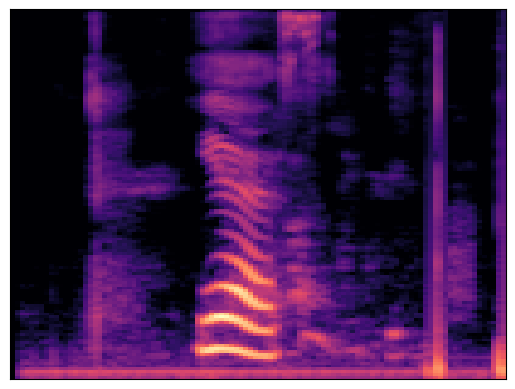

In [11]:
# Define the sampling rate and hop length
SR= 22050
hop_length= 512

#Loop through all audio files in the dataset directory
for i in audio_files:
  if i.endswith('.wav'):
    print(i)
    # Load audio data
    filepath= os.path.join(audio_dir,i)
    y, _= librosa.load(filepath, sr=SR)

    #Compute spectrogram
    S= librosa.feature.melspectrogram(y=y, sr=SR, hop_length=hop_length)

    # Convery power spectrogram to dB
    S_dB= librosa.power_to_db(S, ref=np.max)

    # Save spectrogram as an image
    yes_spectro = os.path.join(output_dir, i +'.png')
    librosa.display.specshow(S_dB, sr=SR, hop_length=hop_length)
    plt.savefig(yes_spectro)


Learning and Training

In [12]:
# import libraries
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential

In [13]:
# Define input and output directories
input_dir= '/content/spectrogram_out'
out_dir= '/content/model_out'

# Load spectrograms and labels
spect= os.listdir(input_dir)
X= []
y= []

for i in spect:
  if i.endswith('.png'):
    spectrogram= tf.keras.preprocessing.image.load_img(
        os.path.join(input_dir, i),
        color_mode= 'grayscale'
    )
    X.append(tf.keras.preprocessing.image.img_to_array(spectrogram))
    y.append(int(i.startswith('positive')))


# Split data into training, validation, and testing sets
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val= train_test_split(X_train, y_train, test_size= 0.2, random_state=42)


# Preprocess data - Normalize input range so each value is between 0 and 1
X_train = np.array(X_train) / 255.0
X_val = np.array(X_val) / 255.0
X_test = np.array(X_test) / 255.0


# Define model architecture
model = tf.keras.Sequential ([
    tf.keras.layers.Input(shape=(X_train.shape[1:])),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# convert numpy array to a list
X_train_list= X_train.tolist()
X_val_list= X_val.tolist()
X_test_list= X_test.tolist()


# Train model
history = model.fit(
    X_train_list, y_train,
    validation_data= (X_val_list, y_val),
    epochs= 20,
    batch_size= 20
)

Epoch 1/20
1/1 [==============================] - 15s 15s/step - loss: 1.0855 - accuracy: 0.3333 - val_loss: 0.4066 - val_accuracy: 1.0000
Epoch 2/20
1/1 [==============================] - 9s 9s/step - loss: 0.8316 - accuracy: 0.5000 - val_loss: 0.6655 - val_accuracy: 1.0000
Epoch 3/20
1/1 [==============================] - 8s 8s/step - loss: 0.5366 - accuracy: 0.8333 - val_loss: 0.8948 - val_accuracy: 0.0000e+00
Epoch 4/20
1/1 [==============================] - 8s 8s/step - loss: 0.9499 - accuracy: 0.5000 - val_loss: 0.6430 - val_accuracy: 1.0000
Epoch 5/20
1/1 [==============================] - 9s 9s/step - loss: 0.9655 - accuracy: 0.1667 - val_loss: 0.4108 - val_accuracy: 1.0000
Epoch 6/20
1/1 [==============================] - 8s 8s/step - loss: 0.5534 - accuracy: 0.8333 - val_loss: 0.1937 - val_accuracy: 1.0000
Epoch 7/20
1/1 [==============================] - 7s 7s/step - loss: 0.9563 - accuracy: 0.1667 - val_loss: 0.0130 - val_accuracy: 1.0000
Epoch 8/20
1/1 [===================

Evaluate and save the model

In [14]:
loss, accuracy = model.evaluate(X_test_list, y_test)
print(f"Test accuracy: {accuracy}")


# save the model
model.save(os.path.join(out_dir, 'wakeword_detector.h5'))
print('model saved')

1/1 [==============================] - 1s 569ms/step - loss: 3.2739e-27 - accuracy: 1.0000
Test accuracy: 1.0
model saved


Convert the model to TFLite 



In [15]:
# Load the Keras model from file
model= tf.keras.models.load_model('/content/model_out/wakeword_detector.h5')

In [16]:
#instantiate converter
converter= tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model= converter.convert()

In [17]:
# report file size in bytes
tflite_models_dir= pathlib.Path("/tmp")
tflite_model_file= tflite_models_dir/'wakeword_model.tflite'
tflite_model_file.write_bytes(tflite_model)

148621552

In [18]:
# open the model to the disk -- edit comment
open("/content/wakeword_model.tflite", "wb").write(tflite_model)

148621552

Quantize the model

In [19]:
# Convert the model to the TensorFlow Lite format with quantization
converter = tf.lite.TFLiteConverter.from_keras_model(tflite_model) 
#converter with default optimizations (quantization is included)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

In [20]:
# Define a generator function that provides our test data's x values # as a representative dataset, and tell the converter to use it
def representative_dataset_generator():
  for value in X_test:
    # Each scalar value must be inside of a 2D array that is wrapped in a list yield [np.array(value, dtype=np.float32, ndmin=2)]
    converter.representative_dataset = representative_dataset_generator # Convert the model
    tflite_model = converter.convert() 

 # Save the model to disk
open("/content/wakeword_model_quantized.tflite", "wb").write(tflite_model)

148621552

In [21]:
# print size of quantized model
tflite_models_dir= pathlib.Path("/tmp")
tflite_model_file= tflite_models_dir/'wakeword_model_quantized.tflite'
tflite_model_file.write_bytes(tflite_model)

148621552

Interpreter for TFLite Models

In [22]:
model1_size = os.path.getsize("/content/wakeword_model.tflite") 
print("Model is %d bytes" % model1_size)
model2_size = os.path.getsize("/content/wakeword_model_quantized.tflite") 
print("Model is %d bytes" % model2_size)

Model is 148621552 bytes
Model is 148621552 bytes


In [23]:
 # Instantiate an interpreter for each model
wakeword_model = tf.lite.Interpreter(model_path='/content/wakeword_model.tflite')
wakeword_model_quantized = tf.lite.Interpreter(model_path='/content/wakeword_model_quantized.tflite')


In [24]:
# Allocate memory for each model
wakeword_model.allocate_tensors()
wakeword_model_quantized.allocate_tensors()

In [28]:
# Get indexes of the input and output tensors of tflite model
wakeword_model_input_details = wakeword_model.get_input_details()
input_shape = wakeword_model_input_details[0]['shape']
#input_data = np.array(..., dtype=np.float32) # input data as a numpy array
X_test1 = X_test.reshape(input_shape)
wakeword_model.set_tensor(wakeword_model_input_details[0]['index'], X_test1)

ValueError: ignored

In [ ]:
# Get indexes of the input and output tensors of tflite model
wakeword_model_input_details = wakeword_model.get_input_details()
wakeword_model_input_index = wakeword_model_input_details[0]["index"]
wakeword_model_output_index = wakeword_model.get_output_details()[0]["index"]

# Get indexes of the input and output tensors of quantized tflite model
wakeword_model_quantized_input_details = wakeword_model_quantized.get_input_details()
wakeword_model_quantized_input_index= wakeword_model_quantized_input_details[0]["index"]
wakeword_model_quantized_output_index = wakeword_model_quantized.get_output_details()[0]["index"]

# Create arrays to store the results
wakeword_model_predictions = []
wakeword_model_quantized_predictions = []

In [ ]:
# Run each model's interpreter for each value and store the results in arrays
for x_value in X_test:
  #Create a 2D tensor wrapping the current x value
  x_value_tensor = tf.convert_to_tensor([[x_value]], dtype=np.float32) 
  # Write the value to the input tensor 
  wakeword_model.set_tensor(wakeword_model_input_index, x_value_tensor)
  # Run inference
  wakeword_model.invoke()
  # Read the prediction from the output tensor

ValueError: ignored

In [ ]:
# Create arrays to store the results
output_data1 = np.empty(output_details1[0]['shape'], dtype=np.float32)
output_data2 = np.empty(output_details2[0]['shape'], dtype=np.float32)

# Run the interpreter for each value and store the results in the arrays
for value in values:
  # Set the input tensor
  input_data = np.array(value, dtype=np.float32)
  interpreter1.set_tensor(input_details1[0]['index'], input_data)
  interpreter2.set_tensor(input_details2[0]['index'], input_data)

  # Run inference
  interpreter1.invoke()
  interpreter2.invoke()

  # Get the output tensor
  output_data1 = interpreter1.get_tensor(output_details1[0]['index'])
  output_data2 = interpreter2.get_tensor(output_details2[0]['index'])

  # Store the results in the arrays
  results1.append(output_data1)
  results2.append(output_data2)


In [ ]:
import subprocess

subprocess.run("xxd -i wakeword_model_quantized.tflite > model_data.cc", shell=True)


CompletedProcess(args='xxd -i wakeword_model_quantized.tflite > model_data.cc', returncode=0)